In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cboo
from matplotlib.backends.backend_pdf import PdfPages
import tqdm

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
import xarray as xr
from gempyor import config, model_info, outcomes, seir, inference_parameter, logloss, inference

import os
from multiprocessing import cpu_count
from gempyor.inference import GempyorInference
import gempyor.postprocess_inference

config_filepath = f"simple_usa_statelevel.yml"
project_path = "synthetic_dataset/"


do_gt = False
do_fit = False

import mlflow

run_id = f"sir_dataset_1"

ncpu = cpu_count()-2
print(f"found {ncpu} CPUs, using these")
generate_notebook=False
gempyor_inference = GempyorInference(
        config_filepath=config_filepath,
        run_id=run_id,
        prefix=None,
        first_sim_index=1,
        stoch_traj_flag=False,
        rng_seed=None,
        nslots=1,
        inference_filename_prefix="",  # usually for {global or chimeric}/{intermediate or final}
        inference_filepath_suffix="",  # usually for the slot_id
        out_run_id=None,  # if out_run_id is different from in_run_id, fill this
        out_prefix=None,  # if out_prefix is different from in_prefix, fill this
        path_prefix=project_path,  # in case the data folder is on another directory
        autowrite_seir=False,
)

nsubpop = len(gempyor_inference.modinf.subpop_struct.subpop_names)
subpop_names = gempyor_inference.modinf.subpop_struct.subpop_names
if generate_notebook:
    for i in range(4):
        gt_df = gempyor_inference.one_simulation(sim_id2write=i, load_ID = False)


INFO:root:Running ModelInfo with outcomes but without Outcomes Modifiers


found 10 CPUs, using these
  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> ModelInfo USA_influpaint_Ro_all; index: 1; run_id: sir_dataset_1,
  gempyor >> prefix: USA_influpaint_inference_all/sir_dataset_1/;


## Generate a ground-truth (do once)
There is already a ground-truth data generated on git, but if you want to make yours, first run:
```bash
cd synthetic_dataset/
rm -r model_output/
gempyor-simulate -c simple_usa_statelevel.yml -n 300
```


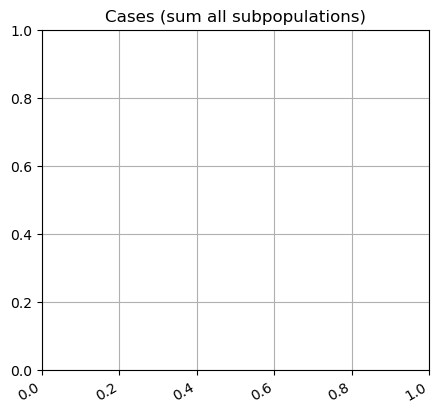

In [2]:
import gempyor
import pandas as pd
import matplotlib.pyplot as plt

df_l = []
for fn in  gempyor.utils.list_filenames(folder="synthetic_dataset/model_output/", filters=["hosp", ".parquet"]):
    df_l.append(gempyor.read_df(fn))
fig, axes = plt.subplots(1,1, figsize=(5,5))
ax = axes
for df in df_l:
    ax.plot(df.set_index("date").groupby("date").sum()["incidCase"], lw=.5)
ax.grid()
ax.set_title("Cases (sum all subpopulations)")
fig.autofmt_xdate()

## Convert to a dataset

In [3]:
# convert to the dataset 
targets = ["incidCase", "incidHosp", "incidDeath"]

ds_xr = xr.DataArray(0, dims=("sample","date", "subpop", "target"), coords={
                                                                            "sample":np.arange(len(df_l)),
                                                                            "date":df_l[0].set_index("date").sort_index().groupby("date").sum().index, 
                                                                            "subpop":subpop_names, 
                                                                            "target":targets
                                                                            })

IndexError: list index out of range

In [4]:
for target in targets:
    for i, df in tqdm.tqdm(enumerate(df_l)):
        ds_xr.loc[i,:, :, target] = df[["date","subpop",target]].pivot(index="date", values=target, columns="subpop")[subpop_names].sort_index().values

3000it [00:02, 1290.90it/s]
3000it [00:02, 1323.22it/s]
3000it [00:02, 1306.41it/s]


In [6]:
filename = f"synthetic_dataset/{run_id}.nc"
ds_xr.attrs["date"] = str(pd.Timestamp.today().date())

ds_xr.to_netcdf(filename)

NameError: name 'ds_xr' is not defined

In [7]:
mlflow.set_experiment("generate_synthetic_data")

with mlflow.start_run(run_name=f"{run_id}_{str(pd.Timestamp.today().date())}"):
    mlflow.log_param("config", config_filepath) # could be a dictionnary as well
    mlflow.log_param("project_path", project_path)
    mlflow.log_figure(fig, "sum_cases.png")
    mlflow.log_artifact(filename, "synthetic_dataset")
    mlflow.log_artifact(project_path+config_filepath, "config")

In [7]:
mlflow.artifacts.download_artifacts(run_id="718d1c439f414b91b824ed5cde223b44", artifact_path="synthetic_dataset/sir_try.nc")

'/Users/chadi/Research/inpainting-idforecasts/mlruns/941976740501509390/718d1c439f414b91b824ed5cde223b44/artifacts/synthetic_dataset/sir_try.nc'